- https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-electronics-store
- https://docs.pola.rs/api/python/stable/reference/index.html

In [1]:
import polars as pl
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [2]:
import plotly.io as pio
custom_layout = dict(title=dict(font=dict(size=20), x=0.5, xanchor='center'))

pio.templates["custom"] = go.layout.Template(layout=go.Layout(custom_layout))
pio.templates.default = "plotly_white+custom"
px.colors.DEFAULT_PLOTLY_COLORS = px.colors.qualitative.Plotly

In [ ]:
dfl = pl.scan_csv(r"D:\Files\Data\big data\eCommerce event history electronic\events.csv")

## Quick Review

In [3]:
dfl.head().collect()

NameError: name 'dfl' is not defined

In [ ]:
dfl.null_count().collect()

In [ ]:
dfl.collect_schema()

## Data Preparation

In [ ]:
# Step 1: Parse "event_time" string to datetime
dfl = dfl.with_columns(
    datetime=pl.col("event_time")
        .str.split(" ")
        .list.slice(0, 2)
        .list.join(" ")
        .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
)

# Step 2: Extract datetime components
dfl = dfl.with_columns([    
    pl.col("datetime").dt.month().alias("month"),  # Extract month (1–12)
    pl.col("datetime").dt.day().alias("day_of_month"),  # Day of month (1–31)
    pl.col("datetime").dt.weekday().alias("day_of_week"),  # Day of week (0=Monday, 6=Sunday)                
    pl.col("datetime").dt.hour().alias("hour")  # Hour of day (0–23)
])

# Step 3: Identify users who never made a purchase
non_purchase_users = (
    dfl.group_by('user_id')
        .agg((pl.col('event_type') == 'purchase').sum().alias("purchase_count"))
        .filter(pl.col("purchase_count") == 0)
        .select("user_id")
        .collect()
)

# Step 4: Filter out non-purchasing users from the main dataset
# dfl = dfl.filter(~pl.col("user_id").is_in(non_purchase_users["user_id"]))

# Step 5: Filter events to only those on or after October 1st, 2020
dfl = dfl.filter(pl.col("datetime") >= pl.datetime(2020, 10, 1))

# Step 6: Categorize product prices
dfl = dfl.with_columns(
    pl.when(pl.col("price") < 10).then(pl.lit("low"))
      .when(pl.col("price") < 100).then(pl.lit("medium"))
      .when(pl.col("price") < 1000).then(pl.lit("high"))
      .otherwise(pl.lit("premium"))
      .alias("price_category")
)

In [ ]:
dfl.collect().write_parquet("events_clean.parquet")

In [4]:
dfl = pl.scan_parquet("events_clean.parquet")

## EDA

### Funnel Proportion

In [37]:
data_funnel = dfl.group_by('event_type').len(name='size').join(
    dfl.select(pl.col("event_type").value_counts(normalize=True)).unnest('event_type'), 
    on='event_type'
).collect().to_pandas()

In [38]:
data_funnel = data_funnel.set_index('event_type')
data_funnel = data_funnel.loc[['view', 'cart', 'purchase']]

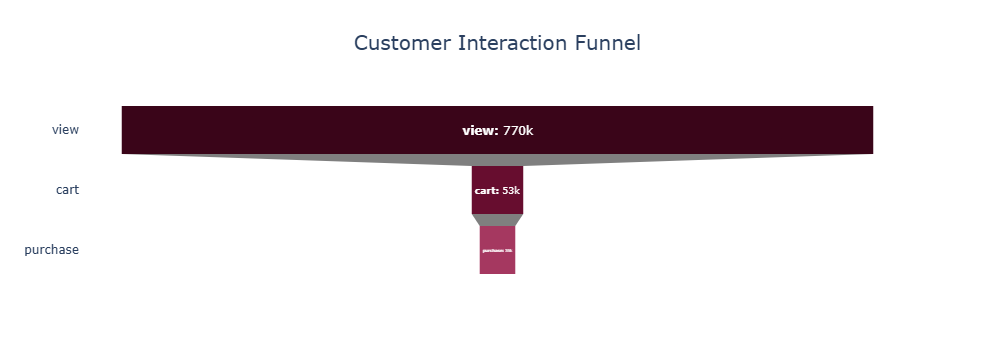

In [39]:
fig = go.Figure(go.Funnel(
    y=data_funnel.index,
    x=data_funnel["size"],
    customdata=data_funnel["proportion"],
    texttemplate= "<b>%{label}: </B>%{value:.2s}",
    textposition='inside',
    marker_color=["#3A0519", "#670D2F", "#A53860"]
    )).update_layout(title_text="Customer Interaction Funnel")
fig

Out of ~857,000 interactions:
- 768,093 (89.6%) viewed a product
- 52,623 (6.1%) added to cart
- 36,339 (4.2%) completed purchase

This shows strong interest up front, but major drop-offs before buying—especially at the cart stage.

### Funnel Proportion by Price Category 

In [40]:
data_funnel_by_price_pct = (
    dfl.group_by(['price_category']).agg(pl.col('event_type').value_counts(normalize=True))
        .collect().explode('event_type').unnest('event_type')
        .pivot(index="event_type", on="price_category", values="proportion")
)[['event_type', 'low', 'medium', 'high', 'premium']]

In [41]:
data_funnel_by_price_pct

event_type,low,medium,high,premium
str,f64,f64,f64,f64
"""view""",0.879711,0.905097,0.88284,0.967137
"""purchase""",0.053711,0.040988,0.044229,0.009939
"""cart""",0.066578,0.053915,0.072931,0.022924


In [42]:
data_funnel_by_price = dfl.group_by(['event_type', 'price_category']).len(name="size").collect()
data_funnel_by_price = data_funnel_by_price.pivot(index="price_category", on="event_type", values="size").to_pandas()

In [43]:
data_funnel_by_price = data_funnel_by_price.set_index("price_category")
data_funnel_by_price = data_funnel_by_price[['view', 'cart', 'purchase']]
data_funnel_by_price = data_funnel_by_price.loc[['low', 'medium', 'high', 'premium']]

In [44]:
fig = go.Figure(layout={'legend_title': 'Price Category (% Purchase)', 'title_text':"Customer Interaction Funnel (by Price Category)"})
colors = ["#3A0519", "#670D2F", "#A53860", "#EF88AD"]
for (idx, data), color in zip(data_funnel_by_price.iterrows(), colors):
    name=f"{idx} ({data['purchase']/data.sum()*100:.2f}%)"    
    fig.add_trace(go.Funnel(name=name, y=data.index, x=data, marker_color=color))    

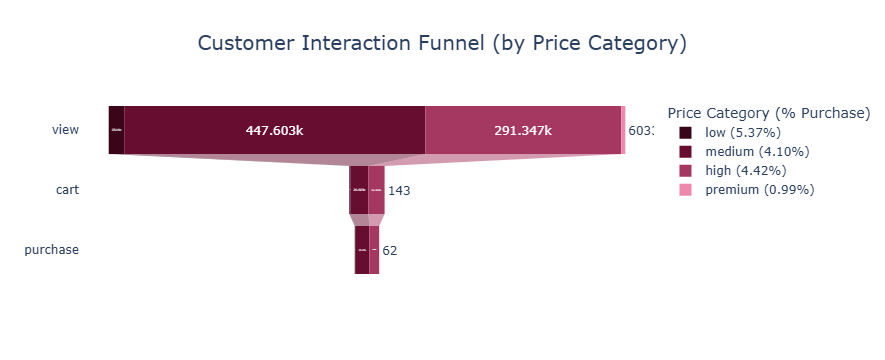

In [45]:
fig

Low-price products attract lower traffic but higher relative conversion:
- Low View: 23,110 (87.97%)
- Cart: 1,749 (6.66%)
- Purchase: 1,411 (5.37%)

Medium-price products show the highest traffic and conversion:
- Medium View: 447,603 (90.5%)
- Cart: 26,663 (5.4%)
- Purchase: 20,270 (4.1%)

High-price products follow closely in volume, with slightly higher cart activity:
- High View: 291,347 (88.3%)
- Cart: 24,068 (7.3%)
- Purchase: 14,596 (4.4%)

Premium products have minimal reach and very low conversion:
- Premium View: 6,033 (96.7%)
- Cart: 143 (2.29%)
- Purchase: 62 (0.99%)

### Repeated Purchase

In [46]:
repeated_purchase = dfl.group_by(['user_id']).agg(Frequency=(pl.col('event_type') == 'purchase').sum())
repeated_purchase = repeated_purchase.sort('Frequency', descending=True).collect()
repeated_purchase = repeated_purchase.group_by('Frequency').len(name='size').sort('Frequency').to_pandas()

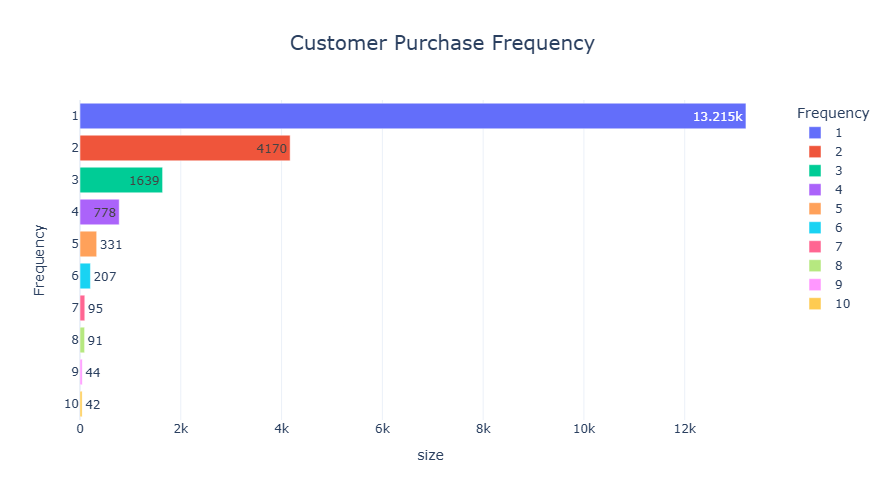

In [47]:
px.bar(
    repeated_purchase.loc[1:10], 
    y='Frequency', 
    x='size', 
    color='Frequency',
    title="Customer Purchase Frequency",
    orientation="h",
    height=500,
    text_auto=True
).update_layout(
    xaxis_tickmode='array', yaxis_tickvals=repeated_purchase.loc[1:10].index, yaxis_autorange="reversed"
)

- 372,374 customers haven’t made a purchase yet.
- Repeat activity is rare:
    - 13,215 bought once
    - 4,170 bought twice
    - Declines sharply down to just 42 customers with 10 purchases.

### Brand Analysis

#### Overall Report

In [48]:
data_brands = dfl.group_by('brand').agg(
    total_revenue = pl.col("price").filter(pl.col("event_type") == "purchase").sum(),
    avg_order_value = pl.col("price").filter(pl.col("event_type") == "purchase").mean(),
    avg_product_price = pl.col("price").mean(),
    min_product_price = pl.col("price").min(),
    max_product_price = pl.col("price").max(),
    n_unique_visitor = pl.col("user_id").n_unique(),
    n_unique_user = pl.col("user_id").filter(pl.col("event_type") == "purchase").n_unique(),
    n_unique_product = pl.col("product_id").n_unique(),
    n_unique_product_with_sale = pl.col("product_id").filter(pl.col("event_type") == "purchase").n_unique(),
    n_view = (pl.col("event_type") == "view").sum(),
    n_cart = (pl.col("event_type") == "cart").sum(),
    n_purchase = (pl.col("event_type") == "purchase").sum(),
    n_interaction = pl.col("event_type").len()    
).with_columns([
    (pl.col("n_cart") / pl.col("n_view") * 100).alias("pct_cart_from_view"),
    (pl.col("n_purchase") / pl.col("n_cart") * 100).alias("pct_purchase_from_cart"),
    (pl.col("n_purchase") / pl.col("n_view") * 100).alias("pct_purchase_from_view"),    
    (pl.col("n_purchase") / pl.col("n_interaction") * 100).alias("pct_purchase"),  
    (pl.col("total_revenue") / pl.col("n_unique_user")).alias("revenue_per_user"),
    (pl.col("n_interaction") / pl.col("n_unique_user")).alias("n_interaction_per_user"),    
    (pl.col("n_purchase") / pl.col("n_unique_product_with_sale")).alias("n_purchase_per_product_with_sale"),
    (pl.col("n_unique_user") / pl.col("n_unique_visitor")).alias("user_conversion_rate"),
]).collect().sort('total_revenue', descending=True)

In [49]:
data_brand_top_product = dfl.group_by("brand", "product_id").agg(
    pl.col("price").filter(pl.col("event_type")=="purchase").sum().alias("top_product_sales")
).sort("top_product_sales", descending=True).group_by("brand", maintain_order=True).first().collect()
data_brand_top_product = data_brand_top_product.rename({"product_id": "top_product_id"})

In [50]:
data_brand_top_niche = dfl.group_by("brand", "category_code").agg(
    pl.col("price").filter(pl.col("event_type")=="purchase").sum().alias("top_niche_sales")
).sort("top_niche_sales", descending=True).group_by("brand", maintain_order=True).first().collect()
data_brand_top_niche = data_brand_top_niche.rename({"category_code": "top_niche"})

In [51]:
data_brands = data_brands.with_columns(brand = pl.col("brand").fill_null("unknown"))
data_brand_top_product = data_brand_top_product.with_columns(brand = pl.col("brand").fill_null("unknown"))
data_brand_top_niche = data_brand_top_niche.with_columns(brand = pl.col("brand").fill_null("unknown"))
data_brands = data_brands.join(data_brand_top_niche, on='brand', how="left").join(data_brand_top_product, on='brand', how='left')

In [53]:
with pl.Config(float_precision=2):
    display(data_brands.head(10))

brand,total_revenue,avg_order_value,avg_product_price,min_product_price,max_product_price,n_unique_visitor,n_unique_user,n_unique_product,n_unique_product_with_sale,n_view,n_cart,n_purchase,n_interaction,pct_cart_from_view,pct_purchase_from_cart,pct_purchase_from_view,pct_purchase,revenue_per_user,n_interaction_per_user,n_purchase_per_product_with_sale,user_conversion_rate,top_niche,top_niche_sales,top_product_id,top_product_sales
str,f64,f64,f64,f64,f64,u32,u32,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64
"""msi""",641430.34,359.95,361.33,8.19,1385.10,7639,1120,176,81,19727,3116,1782,24625,15.80,57.19,9.03,7.24,572.71,21.99,22.00,0.15,"""computers.components.videocard…",633826.08,4079420,85406.90
"""unknown""",586618.99,63.52,77.50,0.22,26909.62,113984,5741,16208,1953,183599,12158,9235,204992,6.62,75.96,5.03,4.51,102.18,35.71,4.73,0.05,"""computers.components.videocard…",258904.14,1821813,213844.24
"""gigabyte""",550079.82,320.75,320.86,45.68,1570.21,9286,1111,198,81,22470,3110,1715,27295,13.84,55.14,7.63,6.28,495.12,24.57,21.17,0.12,"""computers.components.videocard…",534616.55,4099645,163399.14
"""palit""",483691.82,449.95,467.05,43.40,1317.16,9901,778,72,37,21443,2239,1075,24757,10.44,48.01,5.01,4.34,621.71,31.82,29.05,0.08,"""computers.components.videocard…",483691.82,1830099,82270.89
"""asus""",325680.44,264.14,242.78,3.33,4857.32,11850,790,563,123,23692,2088,1233,27013,8.81,59.05,5.20,4.56,412.25,34.19,10.02,0.07,"""computers.components.videocard…",274734.67,3961719,66666.60
"""sapphire""",302801.84,333.12,303.53,44.86,1722.68,3611,576,34,13,7912,1428,909,10249,18.05,63.66,11.49,8.87,525.70,17.79,69.92,0.16,"""computers.components.videocard…",302801.84,893196,81786.20
"""amd""",186327.30,188.40,186.05,23.68,2480.76,7636,558,110,38,16396,1819,989,19204,11.09,54.37,6.03,5.15,333.92,34.42,26.03,0.07,"""computers.components.cpu""",186327.30,3791351,82533.16
"""canon""",132730.88,132.20,148.45,3.19,3398.70,9263,590,368,61,15429,1309,1004,17742,8.48,76.70,6.51,5.66,224.97,30.07,16.46,0.06,"""computers.peripherals.printer""",109508.68,799067,19332.01
"""powercolor""",98404.90,363.12,362.21,48.30,515.40,1719,186,14,5,3488,459,271,4218,13.16,59.04,7.77,6.42,529.06,22.68,54.20,0.11,"""computers.components.videocard…",98404.90,4079061,66713.16


In [54]:
data_funnel_by_brands = data_brands[['brand', 'total_revenue', 'n_view', 'n_cart', 'n_purchase']]
data_funnel_by_brands_others = pl.concat([
    data_funnel_by_brands[:5],
    data_funnel_by_brands[5:].sum().fill_null("others")
])

In [55]:
data_funnel_by_brands_others = data_funnel_by_brands_others.to_pandas().set_index('brand')
data_funnel_by_brands_others

,total_revenue,n_view,n_cart,n_purchase
brand,,,,
msi,641430.34,19727,3116,1782
unknown,586618.99,183599,12158,9235
gigabyte,550079.82,22470,3110,1715
palit,483691.82,21443,2239,1075
asus,325680.44,23692,2088,1233
others,2441541.20,497162,29912,21299


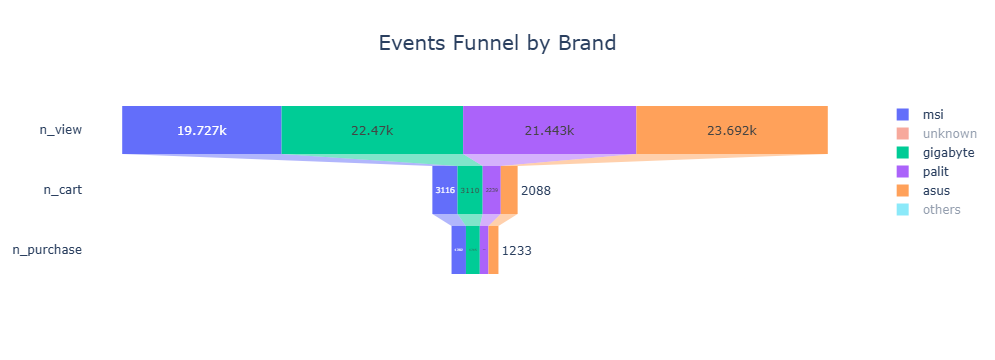

In [56]:
fig = go.Figure(layout={'title_text': 'Events Funnel by Brand'})
for idx, data in data_funnel_by_brands_others.iterrows():
    funnel = go.Funnel(
        name=idx, 
        y=['n_view', 'n_cart', 'n_purchase'], 
        x=data[['n_view', 'n_cart', 'n_purchase']]
    )
    if funnel['name'] in ['others', 'unknown']:
        funnel['visible'] = "legendonly"

    fig.add_trace(funnel)

fig

#### Daily Report

In [57]:
data_brands_daily = dfl.group_by_dynamic("datetime", every="1d", group_by="brand").agg(
    total_revenue = pl.col("price").filter(pl.col("event_type") == "purchase").sum(),
    n_unique_visitor = pl.col("user_id").n_unique(),
    n_unique_user = pl.col("user_id").filter(pl.col("event_type") == "purchase").n_unique(),
    n_unique_product = pl.col("product_id").n_unique(),
    n_unique_product_with_sale = pl.col("product_id").filter(pl.col("event_type") == "purchase").n_unique(),
    n_view = (pl.col("event_type") == "view").sum(),
    n_cart = (pl.col("event_type") == "cart").sum(),
    n_purchase = (pl.col("event_type") == "purchase").sum(),
    n_interaction = pl.col("event_type").len()    
).with_columns([
    (pl.col("n_purchase") / pl.col("n_interaction") * 100).alias("pct_purchase"),    
    (pl.col("n_unique_user") / pl.col("n_unique_visitor")).alias("user_conversion_rate"),
]).group_by("brand").agg(
    total_revenue = pl.col("total_revenue").sum(),
    daily_revenue = pl.col("total_revenue").mean(),    
    daily_unique_visitor = pl.col("n_unique_visitor").mean(),
    daily_unique_user = pl.col("n_unique_user").mean(),
    daily_unique_product = pl.col("n_unique_product").mean(),
    daily_unique_product_with_sale = pl.col("n_unique_product_with_sale").mean(),
    daily_view = pl.col("n_view").mean(),
    daily_cart = pl.col("n_cart").mean(),
    daily_purchase = pl.col("n_purchase").mean(),
    daily_interaction = pl.col("n_interaction").mean(),
    daily_pct_purchase = pl.col("pct_purchase").mean(),
    daily_user_conversion_rate = pl.col("user_conversion_rate").mean()
).collect().sort('total_revenue', descending=True).fill_null("unknown")

In [58]:
with pl.Config(float_precision=2):
    display(data_brands_daily.head(10))

brand,total_revenue,daily_revenue,daily_unique_visitor,daily_unique_user,daily_unique_product,daily_unique_product_with_sale,daily_view,daily_cart,daily_purchase,daily_interaction,daily_pct_purchase,daily_user_conversion_rate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""msi""",641430.34,4247.88,64.30,8.05,35.97,6.23,130.64,20.64,11.80,163.08,6.38,0.11
"""unknown""",586618.99,3884.89,835.15,40.62,673.89,35.12,1215.89,80.52,61.16,1357.56,4.49,0.05
"""gigabyte""",550079.82,3642.91,78.34,7.97,35.89,5.17,148.81,20.60,11.36,180.76,6.05,0.10
"""palit""",483691.82,3203.26,80.54,5.45,18.64,4.00,142.01,14.83,7.12,163.95,4.34,0.07
"""asus""",325680.44,2156.82,92.51,5.64,57.13,4.88,156.90,13.83,8.17,178.89,4.37,0.06
"""sapphire""",302801.84,2005.31,29.25,4.16,10.70,2.37,52.40,9.46,6.02,67.87,7.64,0.12
"""amd""",186327.30,1233.96,62.68,4.23,26.10,3.00,108.58,12.05,6.55,127.18,5.05,0.07
"""canon""",132730.88,879.01,69.79,4.28,28.47,3.37,102.18,8.67,6.65,117.50,5.45,0.06
"""powercolor""",98404.90,660.44,13.66,1.31,2.87,0.84,23.41,3.08,1.82,28.31,5.11,0.09


#### Top 5 Brands

In [59]:
data_brands.with_columns(pl.col(pl.datatypes.Float32, pl.datatypes.Float64).round(3)).head()

brand,total_revenue,avg_order_value,avg_product_price,min_product_price,max_product_price,n_unique_visitor,n_unique_user,n_unique_product,n_unique_product_with_sale,n_view,n_cart,n_purchase,n_interaction,pct_cart_from_view,pct_purchase_from_cart,pct_purchase_from_view,pct_purchase,revenue_per_user,n_interaction_per_user,n_purchase_per_product_with_sale,user_conversion_rate,top_niche,top_niche_sales,top_product_id,top_product_sales
str,f64,f64,f64,f64,f64,u32,u32,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64
"""msi""",641430.34,359.95,361.327,8.19,1385.1,7639,1120,176,81,19727,3116,1782,24625,15.796,57.189,9.033,7.237,572.706,21.987,22.0,0.147,"""computers.components.videocard…",633826.08,4079420,85406.9
"""unknown""",586618.99,63.521,77.5,0.22,26909.62,113984,5741,16208,1953,183599,12158,9235,204992,6.622,75.958,5.03,4.505,102.181,35.707,4.729,0.05,"""computers.components.videocard…",258904.14,1821813,213844.24
"""gigabyte""",550079.82,320.746,320.858,45.68,1570.21,9286,1111,198,81,22470,3110,1715,27295,13.841,55.145,7.632,6.283,495.121,24.568,21.173,0.12,"""computers.components.videocard…",534616.55,4099645,163399.14
"""palit""",483691.82,449.946,467.053,43.4,1317.16,9901,778,72,37,21443,2239,1075,24757,10.442,48.013,5.013,4.342,621.712,31.821,29.054,0.079,"""computers.components.videocard…",483691.82,1830099,82270.89
"""asus""",325680.44,264.137,242.781,3.33,4857.32,11850,790,563,123,23692,2088,1233,27013,8.813,59.052,5.204,4.564,412.254,34.194,10.024,0.067,"""computers.components.videocard…",274734.67,3961719,66666.6


**1. Top Performer by Revenue: MSI**
- Total Revenue: `$641,430.34`
- Avg. Product Price: `$361.327`
- Unique Visitors: 7,639
- Conversion Rate: 14.7% (1120 users)


MSI leads the group in overall revenue and demonstrates strong efficiency in converting users into buyers. Despite having fewer unique users and visitors compared to others, it boasts high conversion rates and revenue per user. Its strong funnel metrics, such as a 57.2% purchase-from-cart rate, indicate a well-optimized purchase journey.

**2. High Traffic, Low Conversion: All Unknown Brand**
- Total Revenue: `$586,618.99`
- Avg. Product Price: `$77.5`
- Unique Visitors: 113,984 (highest, since It includes entries with unknown brand names across all niche product categories)
- Conversion Rate: 5.0% (5741 users)

The unknown brand drives significant traffic and interactions, with the highest views and users. However, its conversion rate is the lowest among the top five. Despite this, it achieves strong revenue by sheer volume and a relatively high purchase-from-cart rate (75.96%), implying that once users add products to cart, they often convert.

**3. Gigabyte: Balanced Performer**
- Total Revenue: `$550,079.82`
- Avg. Product Price: `$320.858`
- Unique Visitors: 9,286
- Conversion Rate: 12.0% (1111 users)

Gigabyte shows a balanced funnel with strong mid-level traffic and high conversion efficiency. With similar purchase and view metrics as MSI, it reflects a well-performing brand with a slightly lower average order value but consistent user engagement.

**4. Palit: High Conversion, Low Scale**
- Total Revenue: `$483,691.82`
- Avg. Product Price: `$467.053`
- Unique Visitors: 9,901
- Conversion Rate: 7.9% (778 users)

Palit, while engaging fewer users, achieves the highest purchase-per-product-sold, indicating focused user intent and high product appeal. It's a niche performer with excellent product-level performance and a strong revenue per user ($621.71).

**5. ASUS: Modest All-Rounder**
- Total Revenue: `$325,680.44`
- Avg. Product Price: `$242.781`
- Unique Visitors: 11,850
- Conversion Rate: 6.7% (790 users)

ASUS shows moderate performance across all funnel stages, with decent engagement and respectable conversion rates. It does not lead in any one area but performs consistently across the board.

In [ ]:
data_brands_daily.with_columns(pl.col(pl.datatypes.Float32, pl.datatypes.Float64).round(3)).head()

**Daily Performance Insights for Top 5 Brands**

This section adds to the funnel analysis by examining **daily metrics** across the top 5 GPU brands: **MSI**, **Unknown**, **Gigabyte**, **Palit**, and **ASUS**. These metrics help reveal patterns in user behavior and performance at a finer resolution.

---

**1. MSI – Efficient Revenue Leader**
- **Daily Revenue**: $4,247.88 (highest)
- **Daily Unique Users**: 8.05
- **Daily Purchase Conversion**: 6.38%
- **User Conversion Rate**: 10.8%

MSI continues to dominate in daily revenue and maintains strong **efficiency per user**. Despite lower traffic, the **high conversion efficiency** reflects strong product appeal and a smooth purchase flow.

---

**2. Unknown – High Traffic, Moderate Efficiency**
- **Daily Unique Visitors**: 835.15 (vastly higher than others)
- **Daily Purchases**: 61.16 (highest in volume)
- **Daily Conversion Rate**: 4.49%
- **User Conversion Rate**: 4.9%

The Unknown brand drives **over 10x more visitors** than any competitor, yet it converts at a modest rate. Despite the massive exposure, there's significant room to improve **visitor-to-user** and **user-to-purchase** transitions.

---

**3. Gigabyte – Steady, High Performer**
- **Daily Revenue**: $3,642.91
- **Daily Conversion Rate**: 6.05%
- **User Conversion Rate**: 9.7%

Gigabyte shows stable and **consistent performance across the board**. It matches MSI in efficiency, even if slightly behind in revenue. Lower product visibility may be limiting growth.

---

**4. Palit – Focused and Effective**
- **Daily Unique Users**: 5.45 (lowest)
- **Daily Purchase Conversion**: 4.34%
- **User Conversion Rate**: 7.1%

Palit remains a **low-volume, high-intent** brand. Its smaller user base is relatively committed, though it lacks the scale to compete on total revenue.

---

**5. ASUS – Under-the-Radar Player**
- **Daily Revenue**: $2,156.82 (lowest)
- **Daily Conversion Rate**: 4.37%
- **User Conversion Rate**: 5.8%

ASUS operates in the mid-tier range of engagement and performance. The brand underperforms slightly in revenue per user, but remains **stable across all metrics**.

#### Top 3 Selling Product Categories per Top 5 Brands

In [116]:
data_brand_top_niches = (
    dfl.with_columns(category_code=pl.col("category_code").fill_null("uncategorized"))
    .group_by("category_code", "brand", maintain_order=True)
    .agg(
        sales=pl.col("price").filter(pl.col("event_type") == "purchase").sum()
    )
    .group_by("brand", maintain_order=True)
    .agg([
        pl.col("sales").sum().alias("total_sales"),            
        pl.struct(["category_code", "sales"]).top_k_by("sales", k=3).alias("top_3_niches_products"),                                
        pl.col("sales").top_k(k=3).sum().alias("top_3_niches_sales_total"),
        (pl.col("sales").top_k(k=3).sum() / pl.col("sales").sum()).alias("top_3_niches_sales_share_pct_total")
    ]).sort("total_sales", descending=True).collect().with_columns(brand=pl.col("brand").fill_null("unknown"))
)

In [117]:
with pl.Config(float_precision=2):
    display(data_brand_top_niches.head(5))

brand,total_sales,top_3_niches_products,top_3_niches_sales_total,top_3_niches_sales_share_pct_total
str,f64,list[struct[2]],f64,f64
"""msi""",641430.34,"[{""computers.components.videocards"",633826.08}, {""computers.components.motherboard"",7080.01}, {""computers.peripherals.mouse"",524.25}]",641430.34,1.00
"""unknown""",586618.99,"[{""computers.components.videocards"",258904.14}, {""uncategorized"",99261.09}, {""electronics.telephone"",65617.75}]",423782.98,0.72
"""gigabyte""",550079.82,"[{""computers.components.videocards"",534616.55}, {""computers.components.motherboard"",15463.27}, {""computers.peripherals.monitor"",0.00}]",550079.82,1.00
"""palit""",483691.82,"[{""computers.components.videocards"",483691.82}]",483691.82,1.00
"""asus""",325680.44,"[{""computers.components.videocards"",274734.67}, {""computers.components.motherboard"",35966.60}, {""computers.peripherals.wifi"",7144.31}]",317845.58,0.98


Across all brands, videocards dominate sales, consistently appearing as the leading niche. Here's the breakdown:
- MSI leads total sales at 641K, with 99% concentrated in videocards.
- The ‘Unknown’ brand ranks second (586K), driven by videocards, uncategorized items, and telephones. Only 72% of sales stem from known product categories.
- Gigabyte closely follows (550K), showing strong performance in videocards and motherboards, though monitor sales are negligible.
- Palit’s entire sales volume (483K) comes from videocards, indicating a highly focused product strategy.
- ASUS earns 326K, with a diverse portfolio across videocards, motherboards, and Wi-Fi peripherals, contributing 98% of total sales.

#### Top 5 Selling Product ids per Top 5 Brands 

In [114]:
data_brand_top_products = (
    dfl
    .group_by("product_id", "brand", maintain_order=True)
    .agg(
        sales=pl.col("price").filter(pl.col("event_type") == "purchase").sum()
    )
    .group_by("brand", maintain_order=True)
    .agg([
        pl.col("sales").sum().alias("total_sales"),            
        pl.struct(["product_id", "sales"]).top_k_by("sales", k=5).alias("top_3_products"),                                
        pl.col("sales").top_k(k=5).sum().alias("top_3_products_sales_total"),
        (pl.col("sales").top_k(k=5).sum() / pl.col("sales").sum()).alias("top_3_products_sales_share")
    ]).sort("total_sales", descending=True).collect()
)

In [115]:
with pl.Config(float_precision=2):
    display(data_brand_top_products.head(5))

brand,total_sales,top_3_products,top_3_products_sales_total,top_3_products_sales_share
str,f64,list[struct[2]],f64,f64
"""msi""",641430.34,"[{4079420,85406.90}, {4102739,78313.06}, … {4154618,35228.27}]",292494.71,0.46
null,586618.99,"[{1821813,213844.24}, {4183872,32849.24}, … {4183873,7423.68}]",280666.35,0.48
"""gigabyte""",550079.82,"[{4099645,163399.14}, {4154414,51883.52}, … {4079421,33565.70}]",326972.94,0.59
"""palit""",483691.82,"[{1830099,82270.89}, {3791509,69511.48}, … {4183863,40432.00}]",285880.97,0.59
"""asus""",325680.44,"[{3961719,66666.60}, {4101569,32811.36}, … {893192,12415.62}]",137524.67,0.42


### Niche Analysis

#### Overall Report

In [ ]:
data_categories = dfl.group_by('category_code').agg(
    total_sales = pl.col("price").filter(pl.col("event_type") == "purchase").sum(),
    n_unique_subcategory = pl.col("category_id").n_unique(),
    n_unique_brand = pl.col("brand").n_unique(),
    n_unique_brand_with_sale = pl.col("brand").filter(pl.col("event_type") == "purchase").n_unique(),
    n_unique_product = pl.col("product_id").n_unique(),
    n_unique_product_with_sale = pl.col("product_id").filter(pl.col("event_type") == "purchase").n_unique(),
    n_unique_visitor = pl.col("user_id").n_unique(),
    n_unique_user = pl.col("user_id").filter(pl.col("event_type") == "purchase").n_unique(),
    n_view = (pl.col("event_type") == "view").sum(),
    n_cart = (pl.col("event_type") == "cart").sum(),
    n_purchase = (pl.col("event_type") == "purchase").sum(),
    n_interaction = pl.col("event_type").len(),
).with_columns([
    (pl.col("n_cart") / pl.col("n_view") * 100).alias("pct_cart_from_view"),
    (pl.col("n_purchase") / pl.col("n_cart") * 100).alias("pct_purchase_from_cart"),
    (pl.col("n_purchase") / pl.col("n_view") * 100).alias("pct_purchase_from_view"),    
    (pl.col("n_purchase") / pl.col("n_interaction") * 100).alias("pct_purchase"),   
    (pl.col("n_purchase") / pl.col("n_unique_user")).alias("n_purchase_per_user"),
    (pl.col("n_unique_user") / pl.col("n_unique_visitor")).alias("user_conversion_rate"),
]).collect()

In [ ]:
with pl.Config(float_precision=2):
    display(data_categories.sort('total_sales', descending=True).head(10))

#### Daily Report

In [ ]:
data_categories_daily = dfl.group_by_dynamic('datetime', every="1d", group_by='category_code').agg(
    daily_sales = pl.col("price").filter(pl.col("event_type") == "purchase").sum(),    
    n_unique_visitor = pl.col("user_id").n_unique(),
    n_unique_user = pl.col("user_id").filter(pl.col("event_type") == "purchase").n_unique(),
    n_view = (pl.col("event_type") == "view").sum(),
    n_cart = (pl.col("event_type") == "cart").sum(),
    n_purchase = (pl.col("event_type") == "purchase").sum(),
    n_interaction = pl.col("event_type").len(),
).with_columns([
    (pl.col("n_purchase") / pl.col("n_interaction") * 100).alias("pct_purchase"),    
    (pl.col("n_unique_user") / pl.col("n_unique_visitor")).alias("user_conversion_rate"),
]).group_by("category_code").agg(
    total_sales = pl.col("daily_sales").sum(),
    total_sold = pl.col("n_purchase").sum(),
    daily_sales = pl.col("daily_sales").mean(),    
    daily_unique_visitor = pl.col("n_unique_visitor").mean(),
    daily_unique_user = pl.col("n_unique_user").mean(),    
    daily_view = pl.col("n_view").mean(),
    daily_cart = pl.col("n_cart").mean(),
    daily_purchase = pl.col("n_purchase").mean(),
    daily_interaction = pl.col("n_interaction").mean(),
    daily_pct_purchase = pl.col("pct_purchase").mean(),
    daily_user_conversion_rate = pl.col("user_conversion_rate").mean()
).collect()

In [ ]:
with pl.Config(float_precision=2):
    display(data_categories_daily.sort('total_sales', descending=True).head(10))

#### Top 3 Brands Within Each Product Niche

In [88]:
data_categories_top_brands = (
    dfl.with_columns(brand=pl.col("brand").fill_null("unknown"))
    .group_by("category_code", "brand", maintain_order=True)
    .agg(
        sales=pl.col("price").filter(pl.col("event_type") == "purchase").sum()
    )
    .group_by("category_code", maintain_order=True)
    .agg([
        pl.col("sales").sum().alias("total_sales"),            
        pl.struct(["brand", "sales"]).top_k_by("sales", k=3).alias("top_3_brands_sales"),                                
        pl.col("sales").top_k(k=3).sum().alias("top_3_brands_sales_total"),
        (pl.col("sales").top_k(k=3).sum() / pl.col("sales").sum()).alias("top_3_brands_sales_share")
    ]).sort("total_sales", descending=True).collect()
    .with_columns(category_code=pl.col("category_code").fill_null("uncategorized"))
)

In [89]:
with pl.Config(float_precision=2):
    display(data_categories_top_brands.head())

category_code,total_sales,top_3_brands_sales,top_3_brands_sales_total,top_3_brands_sales_share
str,f64,list[struct[2]],f64,f64
"""computers.components.videocard…",2589248.70,"[{""msi"",633826.08}, {""gigabyte"",534616.55}, {""palit"",483691.82}]",1652134.45,0.64
"""uncategorized""",479844.27,"[{""unknown"",99261.09}, {""microsoft"",31499.21}, {""sony"",28837.59}]",159597.89,0.33
"""computers.peripherals.printer""",348365.21,"[{""canon"",109508.68}, {""epson"",60140.83}, {""brother"",40459.15}]",210108.66,0.60
"""computers.components.cpu""",212639.80,"[{""amd"",186327.30}, {""intel"",26312.50}, {""dell"",0.00}]",212639.80,1.00
"""electronics.telephone""",146156.96,"[{""unknown"",65617.75}, {""samsung"",21160.89}, {""sirius"",15508.13}]",102286.77,0.70


This analysis highlights brand dominance within the highest-selling product categories:
- Videocards lead with 2.59M in total sales. Top contributors—MSI, Gigabyte, and Palit—collectively account for 64% of the niche, underscoring strong brand concentration.
- The Uncategorized segment, with 480K in sales, shows dispersed brand influence. Unknown, Microsoft, and Sony represent just 33%, hinting at either classification gaps or fragmented market presence.
- Printers follow with 348K in sales. Canon, Epson, and Brother contribute 60%, suggesting moderate brand concentration and healthy competition.
- In CPU sales (213K), AMD and Intel dominate fully with 100% share among top 3, showing a clear duopoly in this niche.
- Telephones (146K) show 70% share from Unknown, Samsung, and Sirius, indicating a mix of major and unclassified brands.

📌 Noteworthy: The CPU category is entirely captured by AMD and Intel, while niches like Uncategorized and Telephones show lower brand consolidation and potential data classification challenges.

### Product Analysis

#### Overall Report

In [118]:
data_products = dfl.group_by('product_id').agg(
    brand = pl.col("brand").first(),
    category = pl.col("category_code").first(),
    price = pl.col("price").first(),        
    total_sales = pl.col("price").filter(pl.col("event_type") == "purchase").sum(),    
    n_unique_visitor = pl.col("user_id").n_unique(),
    n_unique_user = pl.col("user_id").filter(pl.col("event_type") == "purchase").n_unique(),
    n_view = (pl.col("event_type") == "view").sum(),
    n_cart = (pl.col("event_type") == "cart").sum(),
    n_purchase = (pl.col("event_type") == "purchase").sum(),
    n_interaction = pl.col("event_type").len(),
).with_columns([
    (pl.col("n_cart") / pl.col("n_view") * 100).alias("pct_cart_from_view"),
    (pl.col("n_purchase") / pl.col("n_cart") * 100).alias("pct_purchase_from_cart"),
    (pl.col("n_purchase") / pl.col("n_view") * 100).alias("pct_purchase_from_view"),    
    (pl.col("n_purchase") / pl.col("n_interaction") * 100).alias("pct_purchase"),   
    (pl.col("n_purchase") / pl.col("n_unique_user")).alias("n_purchase_per_user"),
    (pl.col("n_unique_user") / pl.col("n_unique_visitor")).alias("user_conversion_rate"),
]).collect()

In [119]:
with pl.Config(float_precision=2):
    display(data_products.sort('total_sales', descending=True).head(10))

product_id,brand,category,price,total_sales,n_unique_visitor,n_unique_user,n_view,n_cart,n_purchase,n_interaction,pct_cart_from_view,pct_purchase_from_cart,pct_purchase_from_view,pct_purchase,n_purchase_per_user,user_conversion_rate
i64,str,str,f64,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64,f64
1821813,null,"""computers.components.videocard…",397.48,213844.24,7056,400,12800,1220,538,14558,9.53,44.10,4.20,3.70,1.34,0.06
4099645,"""gigabyte""","""computers.components.videocard…",292.83,163399.14,2782,388,5435,1024,558,7017,18.84,54.49,10.27,7.95,1.44,0.14
4079420,"""msi""","""computers.components.videocard…",449.51,85406.90,1175,134,2214,369,190,2773,16.67,51.49,8.58,6.85,1.42,0.11
3791351,"""amd""","""computers.components.cpu""",204.29,82533.16,2799,223,5255,723,404,6382,13.76,55.88,7.69,6.33,1.81,0.08
1830099,"""palit""","""computers.components.videocard…",486.81,82270.89,2130,135,3663,369,169,4201,10.07,45.80,4.61,4.02,1.25,0.06
893196,"""sapphire""","""computers.components.videocard…",214.10,81786.20,1530,252,2827,658,382,3867,23.28,58.05,13.51,9.88,1.52,0.16
4078916,"""sapphire""","""computers.components.videocard…",415.54,81445.84,920,142,1538,290,196,2024,18.86,67.59,12.74,9.68,1.38,0.15
4102739,"""msi""","""computers.components.videocard…",294.41,78313.06,1506,195,2615,491,266,3372,18.78,54.18,10.17,7.89,1.36,0.13
4079565,"""sapphire""","""computers.components.videocard…",519.56,69621.04,485,95,809,168,134,1111,20.77,79.76,16.56,12.06,1.41,0.20


#### Daily Report

In [120]:
data_products_daily = dfl.group_by_dynamic('datetime', every="1d", group_by='product_id').agg(
    brand = pl.col("brand").first(),
    category = pl.col("category_code").first(),
    price = pl.col("price").first(),    
    daily_sales = pl.col("price").filter(pl.col("event_type") == "purchase").sum(),    
    n_unique_visitor = pl.col("user_id").n_unique(),
    n_unique_user = pl.col("user_id").filter(pl.col("event_type") == "purchase").n_unique(),
    n_view = (pl.col("event_type") == "view").sum(),
    n_cart = (pl.col("event_type") == "cart").sum(),
    n_purchase = (pl.col("event_type") == "purchase").sum(),
    n_interaction = pl.col("event_type").len(),
).with_columns([
    (pl.col("n_purchase") / pl.col("n_interaction") * 100).alias("pct_purchase"),    
    (pl.col("n_unique_user") / pl.col("n_unique_visitor")).alias("user_conversion_rate"),
]).group_by("product_id").agg(
    brand = pl.col("brand").first(),
    category = pl.col("category").first(),
    price = pl.col("price").first(),
    total_sales = pl.col("daily_sales").sum(),
    total_sold = pl.col("n_purchase").sum(),
    daily_sales = pl.col("daily_sales").mean(),    
    daily_unique_visitor = pl.col("n_unique_visitor").mean(),
    daily_unique_user = pl.col("n_unique_user").mean(),    
    daily_view = pl.col("n_view").mean(),
    daily_cart = pl.col("n_cart").mean(),
    daily_purchase = pl.col("n_purchase").mean(),
    daily_interaction = pl.col("n_interaction").mean(),
    daily_pct_purchase = pl.col("pct_purchase").mean(),
    daily_user_conversion_rate = pl.col("user_conversion_rate").mean()
).collect().sort('total_sales', descending=True)

In [121]:
with pl.Config(float_precision=2):
    display(data_products_daily.head(5))

product_id,brand,category,price,total_sales,total_sold,daily_sales,daily_unique_visitor,daily_unique_user,daily_view,daily_cart,daily_purchase,daily_interaction,daily_pct_purchase,daily_user_conversion_rate
i64,str,str,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64
1821813,null,"""computers.components.videocard…",397.48,213844.24,538,1505.95,58.27,2.96,90.14,8.59,3.79,102.52,3.13,0.05
4099645,"""gigabyte""","""computers.components.videocard…",292.83,163399.14,558,1096.64,22.62,2.78,36.48,6.87,3.74,47.09,7.32,0.12
4079420,"""msi""","""computers.components.videocard…",449.51,85406.90,190,589.01,9.63,0.98,15.27,2.54,1.31,19.12,5.62,0.10
3791351,"""amd""","""computers.components.cpu""",204.29,82533.16,404,546.58,23.17,1.69,34.80,4.79,2.68,42.26,5.69,0.07
1830099,"""palit""","""computers.components.videocard…",486.81,82270.89,169,679.92,19.72,1.13,30.27,3.05,1.40,34.72,3.26,0.06


## Time Analysis

### Over Time Interaction

#### Daily Interaction

In [5]:
data_by_day_freq = dfl.group_by_dynamic("datetime", every="1d").agg(
    sales = pl.col("price").filter(pl.col("event_type") == "purchase").sum(),
    n_view = (pl.col("event_type") == "view").sum(),
    n_cart = (pl.col("event_type") == "cart").sum(),
    n_purchase = (pl.col("event_type") == "purchase").sum(),
    n_interaction = pl.col("event_type").len(),
).collect().to_pandas()

In [135]:
data_by_day_freq_event = data_by_day_freq.melt(id_vars='datetime', value_vars=['n_view', 'n_cart', 'n_purchase'], var_name="event_type", value_name='size')

In [136]:
data_by_day_freq_event['pct_change'] = data_by_day_freq_event.groupby("event_type")["size"].transform("pct_change")
data_by_day_freq_event['size_diff'] = data_by_day_freq_event.groupby("event_type")["size"].transform("diff")

In [138]:
data_by_day_freq_event

,datetime,event_type,size,pct_change,size_diff
0,2020-10-01,n_view,4232,NaN,NaN
1,2020-10-02,n_view,4151,-0.019140,-81.0
2,2020-10-03,n_view,3428,-0.174175,-723.0
3,2020-10-04,n_view,3976,0.159860,548.0
4,2020-10-05,n_view,4499,0.131539,523.0
...,...,...,...,...,...
448,2021-02-24,n_purchase,292,0.186992,46.0
449,2021-02-25,n_purchase,248,-0.150685,-44.0
450,2021-02-26,n_purchase,275,0.108871,27.0
451,2021-02-27,n_purchase,223,-0.189091,-52.0


In [137]:
data_by_day_freq_event[['pct_change', 'size_diff']].mean()

pct_change    0.014868
size_diff     1.357778
dtype: float64

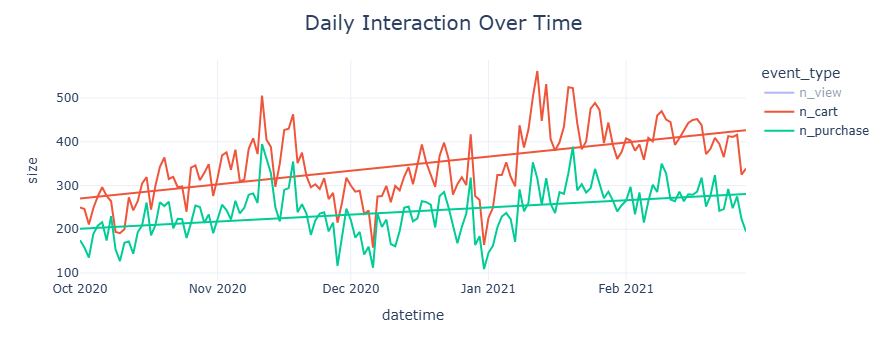

In [132]:
col_y = "size"
fig = px.scatter(data_by_day_freq_event, x='datetime', y=col_y, color='event_type', trendline='ols')
fig.for_each_trace(lambda x: x.update(visible="legendonly") if x['name'] == 'n_view' else x)
fig.update_traces(mode="lines")
fig.update_layout(title_text="Daily Interaction Over Time")

#### Daily Sales

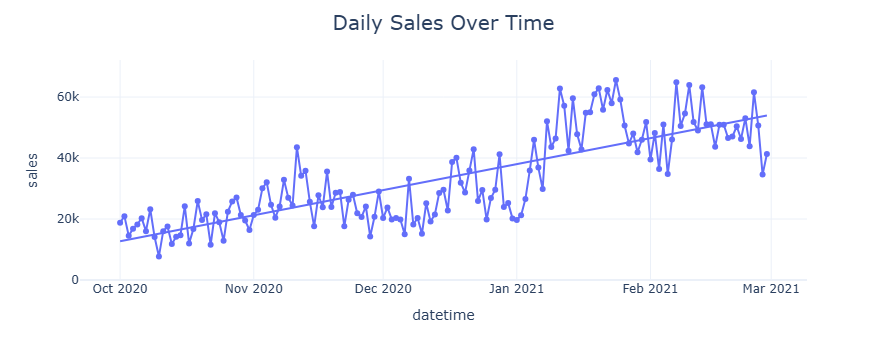

In [133]:
col_y = "sales"
fig = px.scatter(data_by_day_freq, x='datetime', y=col_y, trendline='ols')
fig.data[0].update(mode="lines+markers", texttemplate="%{y}", textposition="top center")
fig.update_layout(yaxis=dict(tickformat=".0s", range=(0, data_by_day_freq[col_y].max() * 1.1)))
fig.update_layout(title_text="Daily Sales Over Time")

#### Weekly Interaction

In [9]:
data_by_week_freq = dfl.group_by_dynamic("datetime", every="1w").agg(
    sales = pl.col("price").filter(pl.col("event_type") == "purchase").sum(),
    n_view = (pl.col("event_type") == "view").sum(),
    n_cart = (pl.col("event_type") == "cart").sum(),
    n_purchase = (pl.col("event_type") == "purchase").sum(),
    n_interaction = pl.col("event_type").len(),
).collect().to_pandas()

In [10]:
data_by_week_freq_event = data_by_week_freq.melt(id_vars='datetime', value_vars=['n_view', 'n_cart', 'n_purchase'], var_name="event_type", value_name='size')

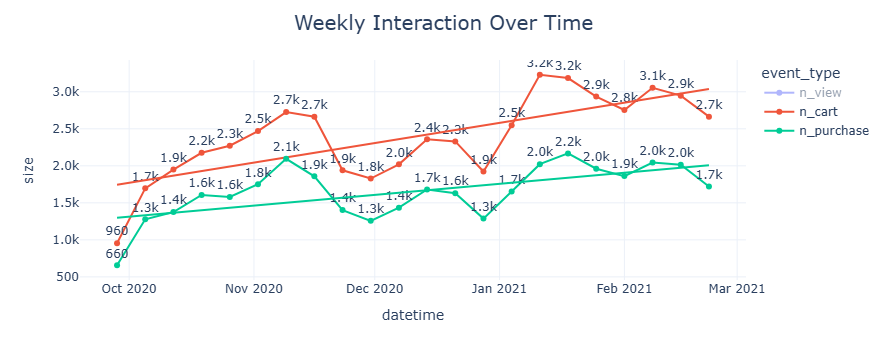

In [11]:
col_y = "size"
fig = px.scatter(data_by_week_freq_event, x='datetime', y=col_y, color='event_type', trendline='ols')
fig.for_each_trace(lambda x: x.update(visible="legendonly") if x['name'] == 'n_view' else x)
fig.data[0].update(mode="lines+markers+text", texttemplate="%{y}", textposition="top center")
fig.data[2].update(mode="lines+markers+text", texttemplate="%{y}", textposition="top center")
fig.data[4].update(mode="lines+markers+text", texttemplate="%{y}", textposition="top center")
fig.update_layout(title_text="Weekly Interaction Over Time")
fig.update_layout(yaxis=dict(tickformat=".2s"))

In [16]:
data_by_week_freq_event['pct_change'] = data_by_week_freq_event.groupby("event_type")["size"].transform("pct_change")
data_by_week_freq_event['size_diff'] = data_by_week_freq_event.groupby("event_type")["size"].transform("diff")

In [19]:
data_by_week_freq_event

,datetime,event_type,size,pct_change,size_diff
0,2020-09-28,n_view,15787,NaN,NaN
1,2020-10-05,n_view,27836,0.763223,12049.0
2,2020-10-12,n_view,32331,0.161482,4495.0
3,2020-10-19,n_view,37503,0.159970,5172.0
4,2020-10-26,n_view,38235,0.019518,732.0
...,...,...,...,...,...
61,2021-01-25,n_purchase,1961,-0.095480,-207.0
62,2021-02-01,n_purchase,1861,-0.050994,-100.0
63,2021-02-08,n_purchase,2045,0.098872,184.0
64,2021-02-15,n_purchase,2016,-0.014181,-29.0


In [21]:
data_by_week_freq_event[['pct_change', 'size_diff']].mean()

pct_change      0.063552
size_diff     328.777778
dtype: float64

#### Weekly Sales

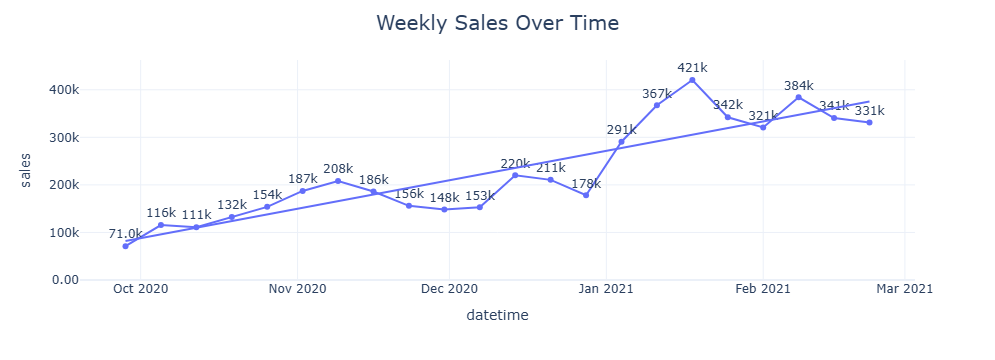

In [12]:
col_y = "sales"
fig = px.scatter(data_by_week_freq, x='datetime', y=col_y, trendline='ols')
fig.data[0].update(mode="lines+markers+text", texttemplate="%{y}", textposition="top center")
fig.update_layout(yaxis=dict(tickformat=".3s", range=(0, data_by_week_freq[col_y].max() * 1.1)))
fig.update_layout(title_text="Weekly Sales Over Time")

### Aggregate Time Interaction

#### 24 Hours Interaction

In [222]:
data_hours = (
    dfl.group_by('hour', 'event_type').len(name='size')
        .collect()
        .pivot(index='hour', on='event_type', values='size')
        .drop_nulls(subset='purchase')        
        .sort('hour')
)[['hour', 'view', 'cart', 'purchase']]

hour_segments = {'0': "Midnight", '1': "Morning", '2': "Afternoon", '3': "Evening"}
data_hours = data_hours.with_columns(time_segment = (pl.col("hour") // 6).cast(pl.String).replace(hour_segments))
data_hours = data_hours.to_pandas()

In [249]:
data_hours_segment = data_hours.groupby("time_segment").sum().assign(
    text=lambda data: data['purchase'].astype(str) + " (" + (data['purchase']/data[['view', 'cart', 'purchase']].sum(axis=1)*100).round(2).astype(str) + "%)"
).sort_values('hour')

In [250]:
fig = go.Figure(layout={'template': 'plotly_white', 'legend_title': 'Time-Segments'})
for idx, data in data_hours_segment.iterrows():
    fig.add_trace(
        go.Funnel(name=f"{idx} | {data['text']}", y=['view', 'cart', 'purchase'], x=data[['view', 'cart', 'purchase']])
    )

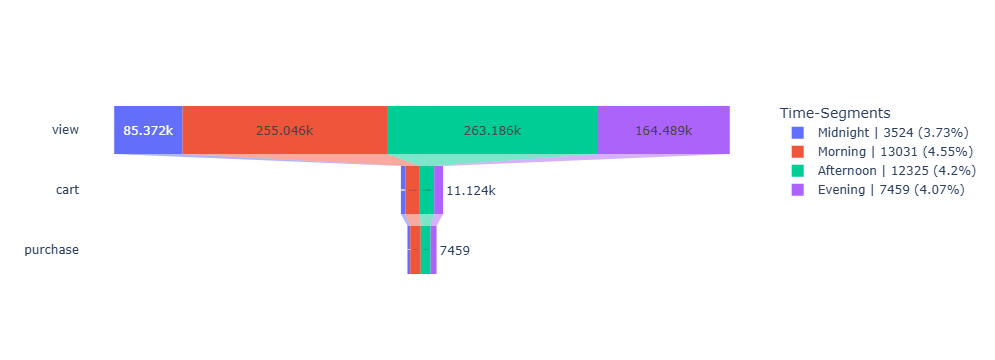

In [247]:
fig

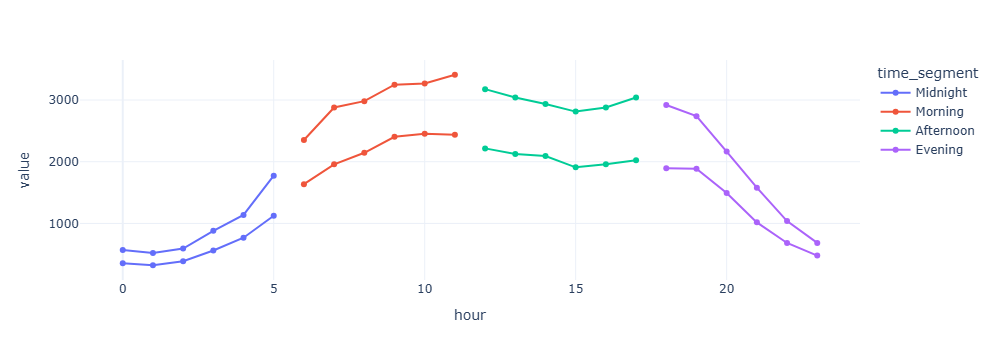

In [283]:
fig = px.line(data_hours, x='hour', y=['purchase', 'cart'], color='time_segment', markers=True).update_layout(hovermode='x')
fig.for_each_trace(lambda t: t.update(hovertemplate='<br>'.join(np.array(t['hovertemplate'].split('<br>'))[[1, 3]])))

#### Day of Week Interaction

In [284]:
dayofweek = (
    dfl.group_by('day_of_week', 'event_type').len(name='size')
        .collect()
        .pivot(index='day_of_week', on='event_type', values='size')
        .drop_nulls(subset='purchase')        
        .sort('day_of_week')
)[['day_of_week', 'view', 'cart', 'purchase']]

In [285]:
dayofweek_text = dayofweek.with_columns(
    text = pl.format(
        "{} ({}%)",
        pl.col("purchase"),
        (pl.col("purchase") / pl.sum_horizontal("view", "cart", "purchase") * 100).round(2)        
    )
)

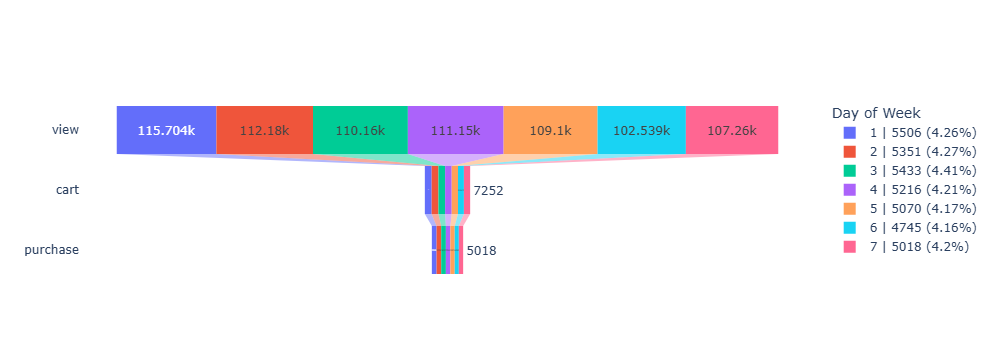

In [286]:
go.Figure(
    [go.Funnel(name=f"{data[0]} | {data[-1]}", y=['view', 'cart', 'purchase'], x=data[1:-1]) for data in dayofweek_text.iter_rows()]
    , layout={'template': 'plotly_white', 'legend_title': 'Day of Week'}
)

#### Day of Month Interaction

In [287]:
day_of_month = (
    dfl.group_by('day_of_month', 'event_type').len(name='size')
        .collect()
        .pivot(index='day_of_month', on='event_type', values='size')
        .drop_nulls(subset='purchase')        
        .sort('day_of_month')
)[['day_of_month', 'view', 'cart', 'purchase']]

In [288]:
day_of_month_text = day_of_month.with_columns(
    text = pl.format(
        "{} ({}%)",
        pl.col("purchase"),
        (pl.col("purchase") / pl.sum_horizontal("view", "cart", "purchase") * 100).round(2)        
    )
)

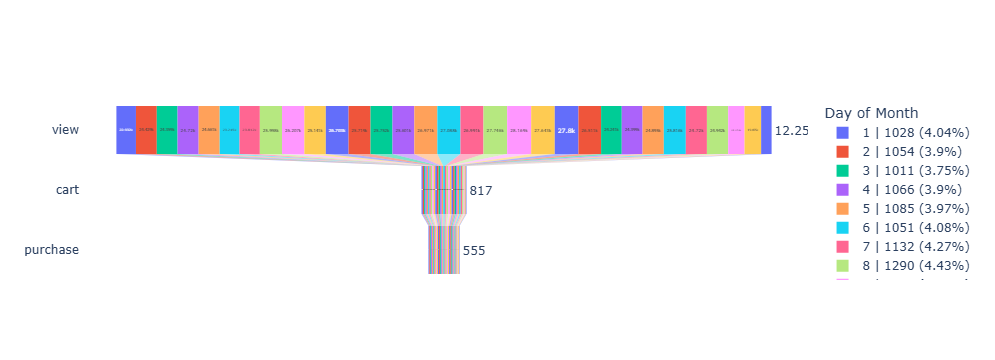

In [289]:
go.Figure(
    [go.Funnel(name=f"{data[0]} | {data[-1]}", y=['view', 'cart', 'purchase'], x=data[1:-1]) for data in day_of_month_text.iter_rows()]
    , layout={'template': 'plotly_white', 'legend_title': 'Day of Month'}
)

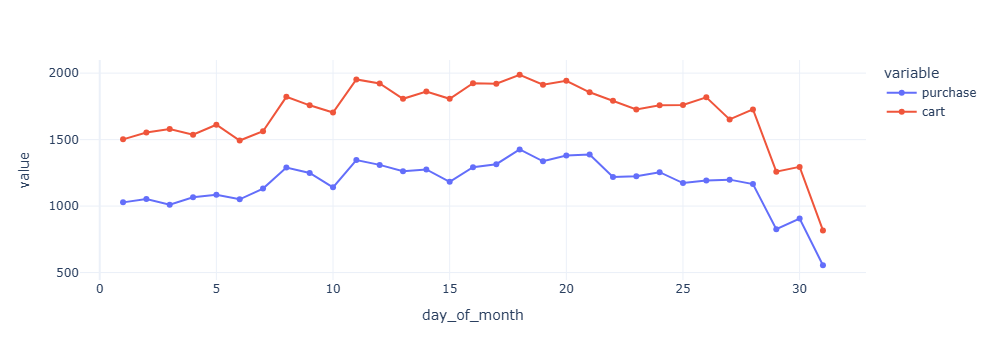

In [320]:
px.line(day_of_month, x='day_of_month', y=['purchase', 'cart'], markers=True).update_layout(hovermode='x').update_traces(hovertemplate=None)

#### Month of Year Interaction

In [321]:
months = (
    dfl.group_by('month', 'event_type').len(name='size')
        .collect()
        .pivot(index='month', on='event_type', values='size')
        .drop_nulls(subset='purchase')        
        .sort('month')
)[['month', 'view', 'cart', 'purchase']]

In [322]:
months_text = months.with_columns(
    text = pl.format(
        "{} ({}%)",
        pl.col("purchase"),
        (pl.col("purchase") / pl.sum_horizontal("view", "cart", "purchase") * 100).round(2)        
    )
)

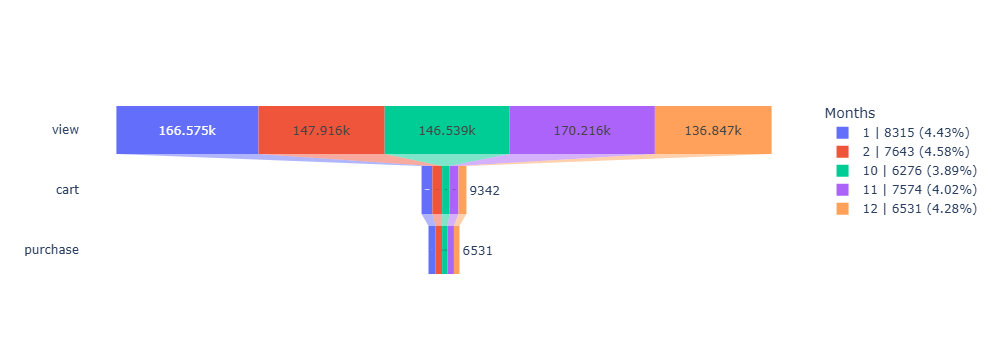

In [323]:
go.Figure(
    [go.Funnel(name=f"{data[0]} | {data[-1]}", y=['view', 'cart', 'purchase'], x=data[1:-1]) for data in months_text.iter_rows()]
    , layout={'template': 'plotly_white', 'legend_title': 'Months'}
)

## Customer Behaviour Analysis

### Overall Report

In [22]:
data_users = dfl.group_by('user_id').agg(
    n_unique_session = pl.col("user_session").n_unique(),
    total_spend = pl.col("price").filter(pl.col("event_type") == "purchase").sum(),
    avg_order_value = pl.col("price").filter(pl.col("event_type") == "purchase").mean(),    
    time_to_first_purchase = pl.col("datetime").filter(pl.col("event_type") == "purchase").min() - pl.col("datetime").min(),
    n_unique_brand = pl.col("brand").n_unique(),
    n_unique_brand_cart = pl.col("brand").filter(pl.col("event_type") == "cart").n_unique(),
    n_unique_brand_purchased = pl.col("brand").filter(pl.col("event_type") == "purchase").n_unique(),
    n_unique_product = pl.col("product_id").n_unique(),    
    n_unique_product_cart = pl.col("product_id").filter(pl.col("event_type") == "cart").n_unique(),
    n_unique_product_purchased = pl.col("product_id").filter(pl.col("event_type") == "purchase").n_unique(),
    n_view = (pl.col("event_type") == "view").sum(),
    n_cart = (pl.col("event_type") == "cart").sum(),
    n_purchase = (pl.col("event_type") == "purchase").sum(),
    n_interaction = pl.col("event_type").len()    
).with_columns([    
    (pl.col("n_cart") / pl.col("n_view") * 100).alias("pct_cart_from_view"),
    (pl.col("n_purchase") / pl.col("n_cart") * 100).alias("pct_purchase_from_cart"),
    (pl.col("n_purchase") / pl.col("n_view") * 100).alias("pct_purchase_from_view"),    
    (pl.col("n_purchase") / pl.col("n_interaction") * 100).alias("pct_purchase"),  
    (pl.col("n_purchase") / pl.col("n_unique_product_purchased")).alias("n_purchase_per_purchased_product"),
    (pl.col("n_purchase") / pl.col("n_unique_brand_purchased")).alias("n_purchase_per_purchased_brand"),
]).collect()

In [24]:
with pl.Config(float_precision=2):
    display(data_users.sort('total_spend', descending=True).head(10))

user_id,n_unique_session,total_spend,avg_order_value,time_to_first_purchase,n_unique_brand,n_unique_brand_cart,n_unique_brand_purchased,n_unique_product,n_unique_product_cart,n_unique_product_purchased,n_view,n_cart,n_purchase,n_interaction,pct_cart_from_view,pct_purchase_from_cart,pct_purchase_from_view,pct_purchase,n_purchase_per_purchased_product,n_purchase_per_purchased_brand
i64,u32,f64,f64,duration[μs],u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64,f64
1515915625601579158,5,12080.83,215.73,1h 49m 1s,12,7,7,40,27,19,79,35,56,170,44.30,160.00,70.89,32.94,2.95,8.00
1515915625530137422,4,9418.62,523.26,25m 33s,5,5,5,10,10,9,17,11,18,46,64.71,163.64,105.88,39.13,2.00,3.60
1515915625547240612,9,8639.69,539.98,3m 52s,3,3,3,10,6,5,19,12,16,47,63.16,133.33,84.21,34.04,3.20,5.33
1515915625600723220,2,8447.61,444.61,36m 39s,8,7,7,27,19,18,30,19,19,68,63.33,100.00,63.33,27.94,1.06,2.71
1515915625596222123,1,8047.99,335.33,22h 50m 45s,14,6,5,33,9,5,150,25,24,199,16.67,96.00,16.00,12.06,4.80,4.80
1515915625591659523,3,6629.87,135.30,7d 19h 20m 47s,39,12,11,136,24,15,248,42,49,339,16.94,116.67,19.76,14.45,3.27,4.45
1515915625596534847,12,6286.98,139.71,2d 6h 11m 35s,11,9,7,19,11,7,59,34,45,138,57.63,132.35,76.27,32.61,6.43,6.43
1515915625596298594,2,5931.08,988.51,11m 15s,3,3,2,7,7,3,13,9,6,28,69.23,66.67,46.15,21.43,2.00,3.00
1515915625602773715,1,5705.96,300.31,29m 10s,5,4,4,11,7,7,19,10,19,48,52.63,190.00,100.00,39.58,2.71,4.75


### Sessional Report

In [25]:
data_users_sessional = (
    dfl
    .group_by(['user_id', 'user_session'])
    .agg(        
        start_session = pl.col("datetime").min(),
        end_session = pl.col("datetime").max(),
        session_duration = pl.col("datetime").max() - pl.col("datetime").min(),        
        total_spend = pl.col("price").filter(pl.col("event_type") == "purchase").sum(),
        avg_order_value = pl.col("price").filter(pl.col("event_type") == "purchase").mean(),  
        n_view = (pl.col("event_type") == "view").sum(),
        n_cart = (pl.col("event_type") == "cart").sum(),
        n_purchase = (pl.col("event_type") == "purchase").sum(),
        n_interaction = pl.col("event_type").len()    
    ).sort(['user_id', 'start_session']).collect()
)

In [27]:
with pl.Config(float_precision=2):
    display(data_users_sessional.sort('total_spend', descending=True).head(10))

user_id,user_session,start_session,end_session,session_duration,total_spend,avg_order_value,n_view,n_cart,n_purchase,n_interaction
i64,str,datetime[μs],datetime[μs],duration[μs],f64,f64,u32,u32,u32,u32
1515915625600723220,"""D9N9FhMEhS""",2021-02-04 21:11:53,2021-02-04 22:09:55,58m 2s,8447.61,444.61,29,19,19,67
1515915625596222123,"""SXPLbE3Ybs""",2021-01-23 11:44:05,2021-02-01 17:19:23,9d 5h 35m 18s,8047.99,335.33,150,25,24,199
1515915625596298594,"""IeWQDvynKP""",2021-01-23 16:10:05,2021-01-24 16:57:42,1d 47m 37s,5931.08,988.51,6,5,6,17
1515915625591659523,"""F6ohHpTTBU""",2021-01-11 22:18:27,2021-02-02 11:32:56,21d 13h 14m 29s,5873.36,133.49,213,36,44,293
1515915625602773715,"""dNG0UZsqFT""",2021-02-08 05:45:33,2021-02-08 22:38:22,16h 52m 49s,5705.96,300.31,19,10,19,48
1515915625601579158,"""UrgkcsrOv0""",2021-02-06 23:53:51,2021-02-07 02:35:14,2h 41m 23s,5174.19,199.01,39,19,26,84
1515915625601579158,"""g8VLNyl2AA""",2021-02-07 05:47:22,2021-02-07 09:25:32,3h 38m 10s,4822.48,229.64,35,15,21,71
1515915625530137422,"""Z8SKcaYExQ""",2020-11-04 11:16:48,2020-11-04 11:27:10,10m 22s,4709.31,523.26,3,1,9,13
1515915625600741673,"""9BlYIq0jL9""",2021-02-07 09:02:57,2021-02-07 09:27:17,24m 20s,4493.10,499.23,3,2,9,14


### Customer Journey Behaviour

#### Overall Activity Records

In [31]:
user_id = 1515915625537803839
data_user = dfl.filter(pl.col('user_id')==user_id).collect()

In [32]:
data_user_transaction = data_user.group_by('brand', 'product_id').agg(
    price = pl.col("price").first(),
    n_session = pl.col("user_session").n_unique(),
    n_view = pl.col("datetime").filter(pl.col("event_type") == "view").len(),
    n_cart = pl.col("datetime").filter(pl.col("event_type") == "cart").len(),
    n_purchase = pl.col("datetime").filter(pl.col("event_type") == "purchase").len(),
    n_interaction = pl.col("event_type").len(),
    start_view = pl.col("datetime").filter(pl.col("event_type") == "view").min(),
    end_view = pl.col("datetime").filter(pl.col("event_type") == "view").max(),    
    start_cart = pl.col("datetime").filter(pl.col("event_type") == "cart").min(),    
    end_cart = pl.col("datetime").filter(pl.col("event_type") == "cart").max(),    
    start_purchase = pl.col("datetime").filter(pl.col("event_type") == "purchase").min(),
    end_purchase = pl.col("datetime").filter(pl.col("event_type") == "purchase").max(),
).with_columns(        
    view_to_cart_time = pl.col("start_cart") - pl.col("start_view"),
    cart_to_purchase_time = pl.col("start_purchase") - pl.col("start_cart"),
    time_spend = pl.col("start_purchase") - pl.col("start_view"),
    money_spend = pl.col("price") * pl.col("n_purchase"),
)

In [33]:
data_user_transaction.sort("start_view")

brand,product_id,price,n_session,n_view,n_cart,n_purchase,n_interaction,start_view,end_view,start_cart,end_cart,start_purchase,end_purchase,view_to_cart_time,cart_to_purchase_time,time_spend,money_spend
str,i64,f64,u32,u32,u32,u32,u32,datetime[μs],datetime[μs],datetime[μs],datetime[μs],datetime[μs],datetime[μs],duration[μs],duration[μs],duration[μs],f64
"""aerocool""",1036404,163.48,201,211,3,2,216,2020-11-10 14:38:56,2021-02-24 13:26:48,2020-11-10 14:40:56,2021-01-31 13:41:48,2021-01-24 20:15:12,2021-01-31 13:41:59,2m,75d 5h 34m 16s,75d 5h 36m 16s,326.96
"""aerocool""",4170970,44.7,51,51,0,0,51,2020-11-15 08:59:09,2020-11-28 15:12:30,null,null,null,null,null,null,null,0.0
"""formula""",1756725,35.54,1,1,0,0,1,2020-11-15 09:00:57,2020-11-15 09:00:57,null,null,null,null,null,null,null,0.0
"""aerocool""",1341783,59.71,1,1,0,0,1,2020-11-15 09:02:12,2020-11-15 09:02:12,null,null,null,null,null,null,null,0.0
"""accord""",3721192,33.19,37,45,4,2,51,2020-12-21 18:38:43,2021-01-08 12:07:58,2020-12-21 18:45:49,2020-12-21 19:03:58,2020-12-21 19:01:17,2020-12-21 19:02:13,7m 6s,15m 28s,22m 34s,66.38
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""formula""",3829452,34.56,1,1,0,0,1,2021-01-28 04:43:01,2021-01-28 04:43:01,null,null,null,null,null,null,null,0.0
null,829999,92.14,1,1,0,0,1,2021-01-28 04:44:28,2021-01-28 04:44:28,null,null,null,null,null,null,null,0.0
"""deepcool""",1587234,76.41,1,1,0,0,1,2021-01-28 05:11:22,2021-01-28 05:11:22,null,null,null,null,null,null,null,0.0


#### Sessional Activity Records

In [34]:
user_id = 1515915625537803839
data_user = dfl.filter(pl.col('user_id')==user_id).collect()

In [35]:
dfl_user_session = (
    data_user.group_by('user_session').agg(
        start_session = pl.col("datetime").max(),
        end_session = pl.col("datetime").min(),
        session_duration = pl.col("datetime").max() - pl.col("datetime").min(),            
        n_view = (pl.col('event_type') == 'view').sum(),
        n_cart = (pl.col('event_type') == 'cart').sum(),
        n_purchase = (pl.col('event_type') == 'purchase').sum(),
        n_interaction = pl.col('event_type').len()
    )
).sort("start_session")

In [36]:
dfl_user_session

user_session,start_session,end_session,session_duration,n_view,n_cart,n_purchase,n_interaction
str,datetime[μs],datetime[μs],duration[μs],u32,u32,u32,u32
"""Nekb5ckivx""",2020-11-10 14:38:56,2020-11-10 14:38:56,0µs,1,0,0,1
"""YONih8qhXe""",2020-11-10 14:40:56,2020-11-10 14:39:17,1m 39s,2,1,0,3
"""CfV0V4HYa8""",2020-11-10 17:21:12,2020-11-10 17:21:12,0µs,1,0,0,1
"""mS1osFYAZq""",2020-11-11 16:01:25,2020-11-11 16:01:25,0µs,1,0,0,1
"""9FaYHi600W""",2020-11-11 20:11:37,2020-11-11 20:11:37,0µs,1,0,0,1
…,…,…,…,…,…,…,…
"""5BHM2RNdHT""",2021-02-01 16:11:59,2021-02-01 16:11:59,0µs,1,0,0,1
"""0dJ0rtuV06""",2021-02-02 14:32:35,2021-02-02 14:32:35,0µs,1,0,0,1
"""DZtN5qXZoM""",2021-02-03 12:36:22,2021-02-03 12:36:22,0µs,1,0,0,1
